In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os

from typing import Tuple
import numpy.typing as npt

plt.style.use(['science', 'ieee', 'no-latex'])

In [9]:
NA = 0.86
LAMBDA = 248
K = 2 * np.pi / LAMBDA
W = NA / LAMBDA
THRESHOLD = 0.5

target_path = './img_test/single_slit'
if not os.path.isdir(target_path):
	os.makedirs(target_path)

In [10]:
# sampling rate
Fs_single = 1000
# single slit space
s_single_space = 1000
s_single_width = 100
s_single = np.linspace(
	-s_single_space, s_single_space, 
	2 * s_single_space * Fs_single + 1,
	dtype=np.double
)
# single slit mask
s_single_mask = np.where(np.abs(s_single) <= s_single_width, 1, 0)
# freq
N = (s_single.shape[0] - 1) // 2
freq = Fs_single * np.arange(-N, N + 1) / (2 * N)
s_source = np.zeros_like(freq)

In [11]:
def max_source(s_source: npt.NDArray, d: float, lbd: int, na: float) -> int:
	return int(s_source.shape[0] * d * na / lbd)

In [12]:
n = max_source(s_source, s_single[1] - s_single[0], LAMBDA, NA)
s_source[0:n] = 1
s_source[-n+1:] = 1
s_source[0:n], s_source[-n+1:]

(array([1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1.]))

In [13]:
def freq_and_Eoutshift(
	s: npt.NDArray,
	E_out_unshift: npt.NDArray,
	Fs: int
) -> Tuple[npt.NDArray, npt.NDArray]:
	N = (s.shape[0] - 1) // 2
	freq = Fs * np.arange(-N, N + 1) / (2 * N)
	E_out_shift = np.concatenate((E_out_unshift[N + 1:], E_out_unshift[:N + 1]))
	return freq, E_out_shift

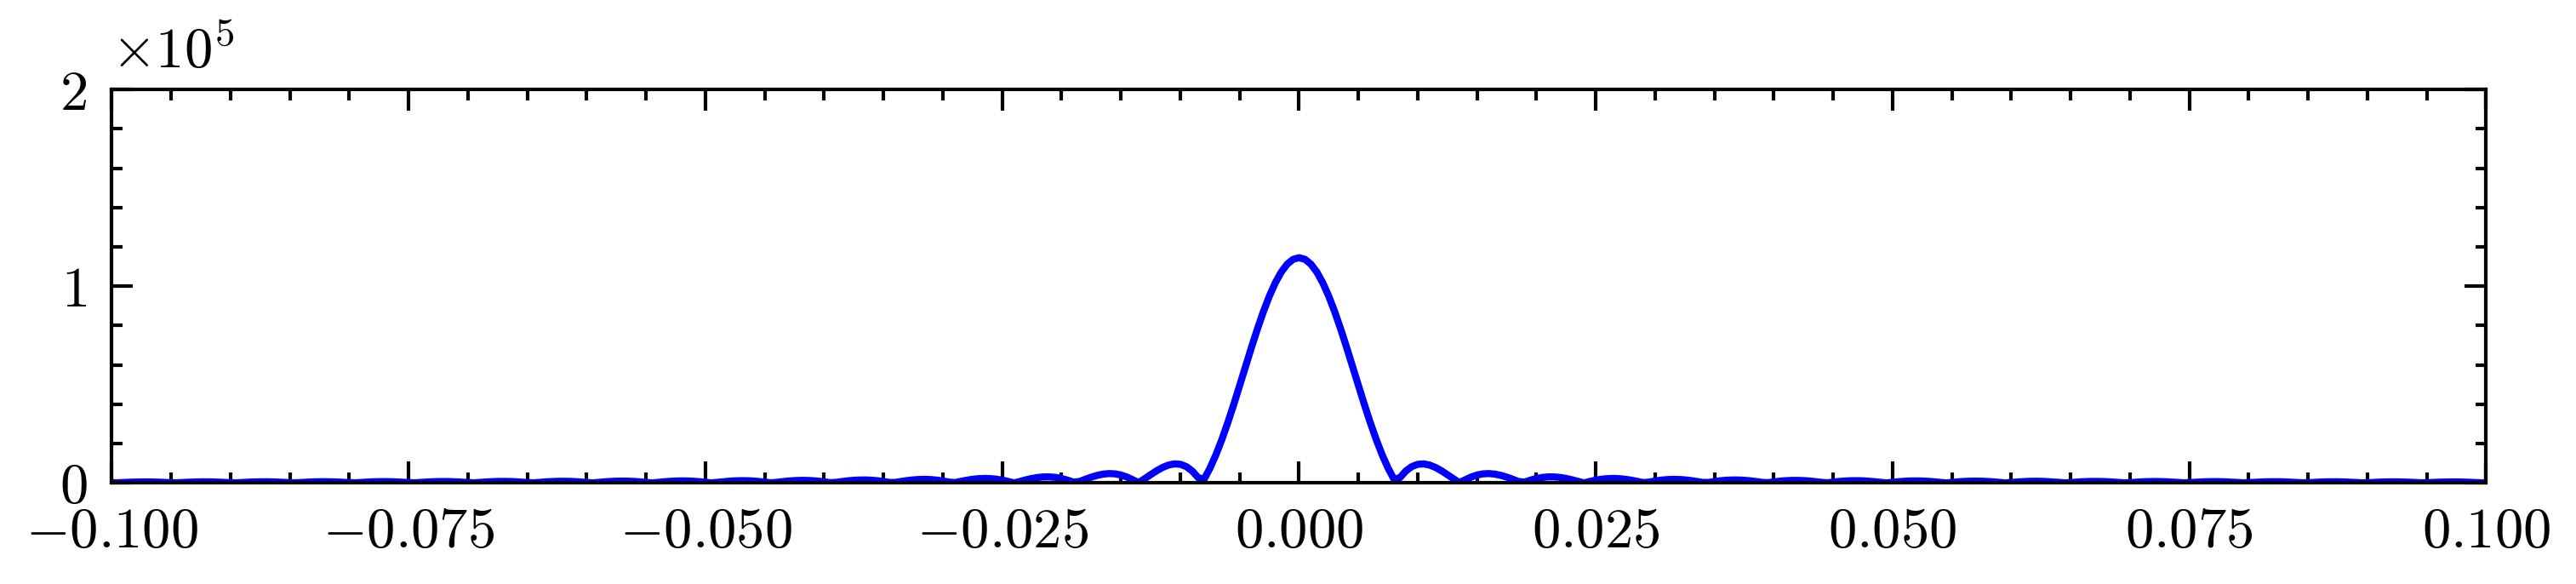

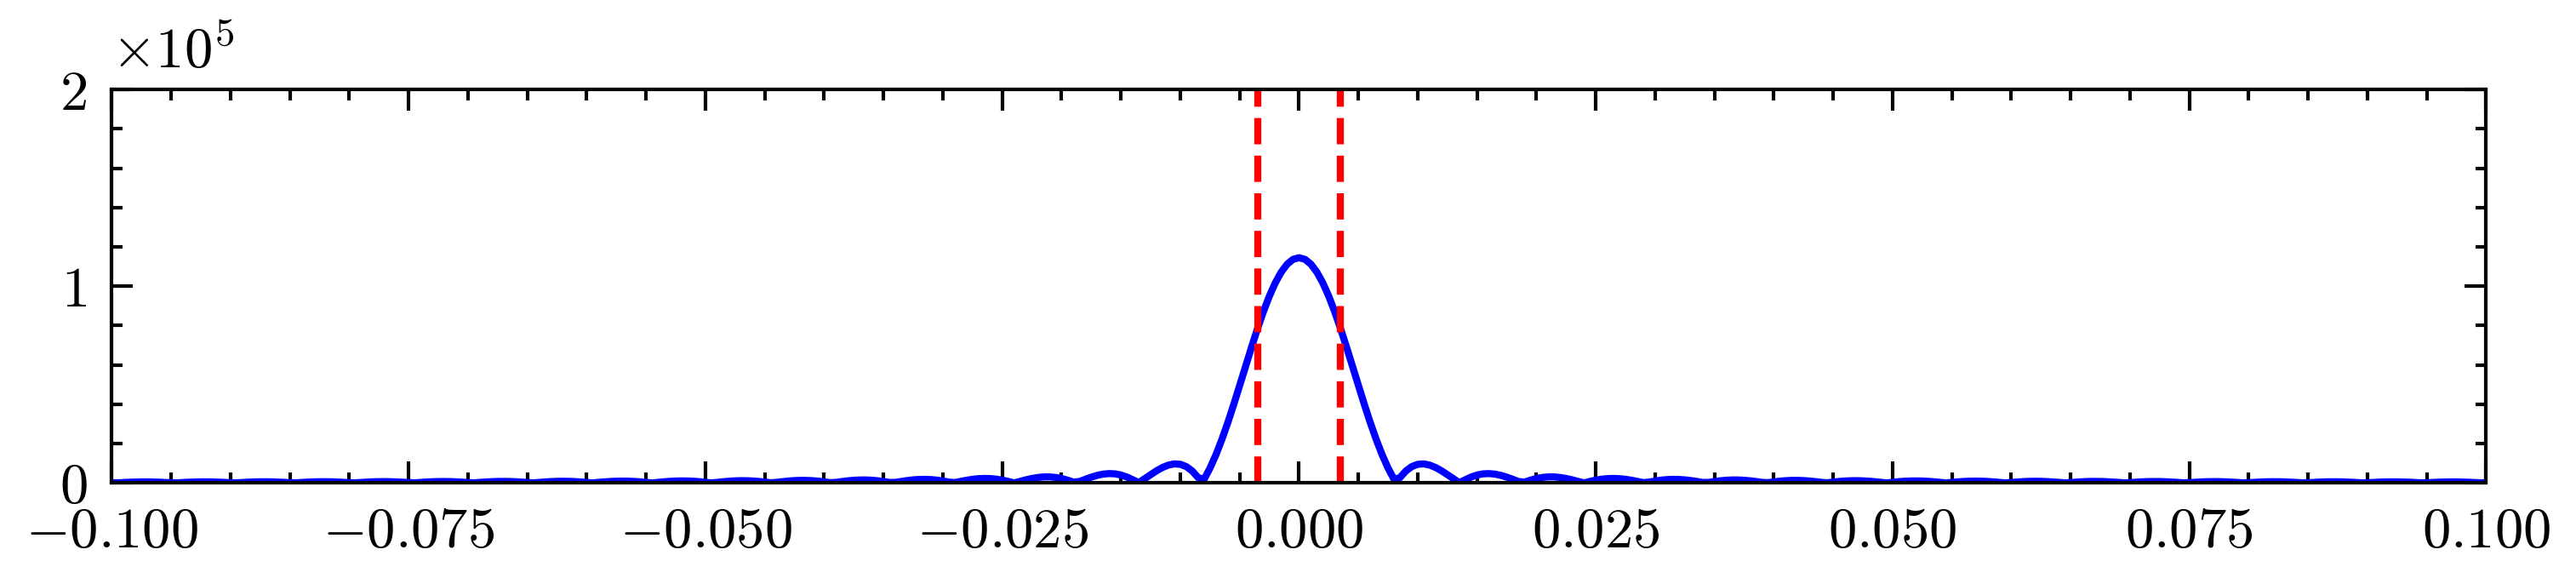

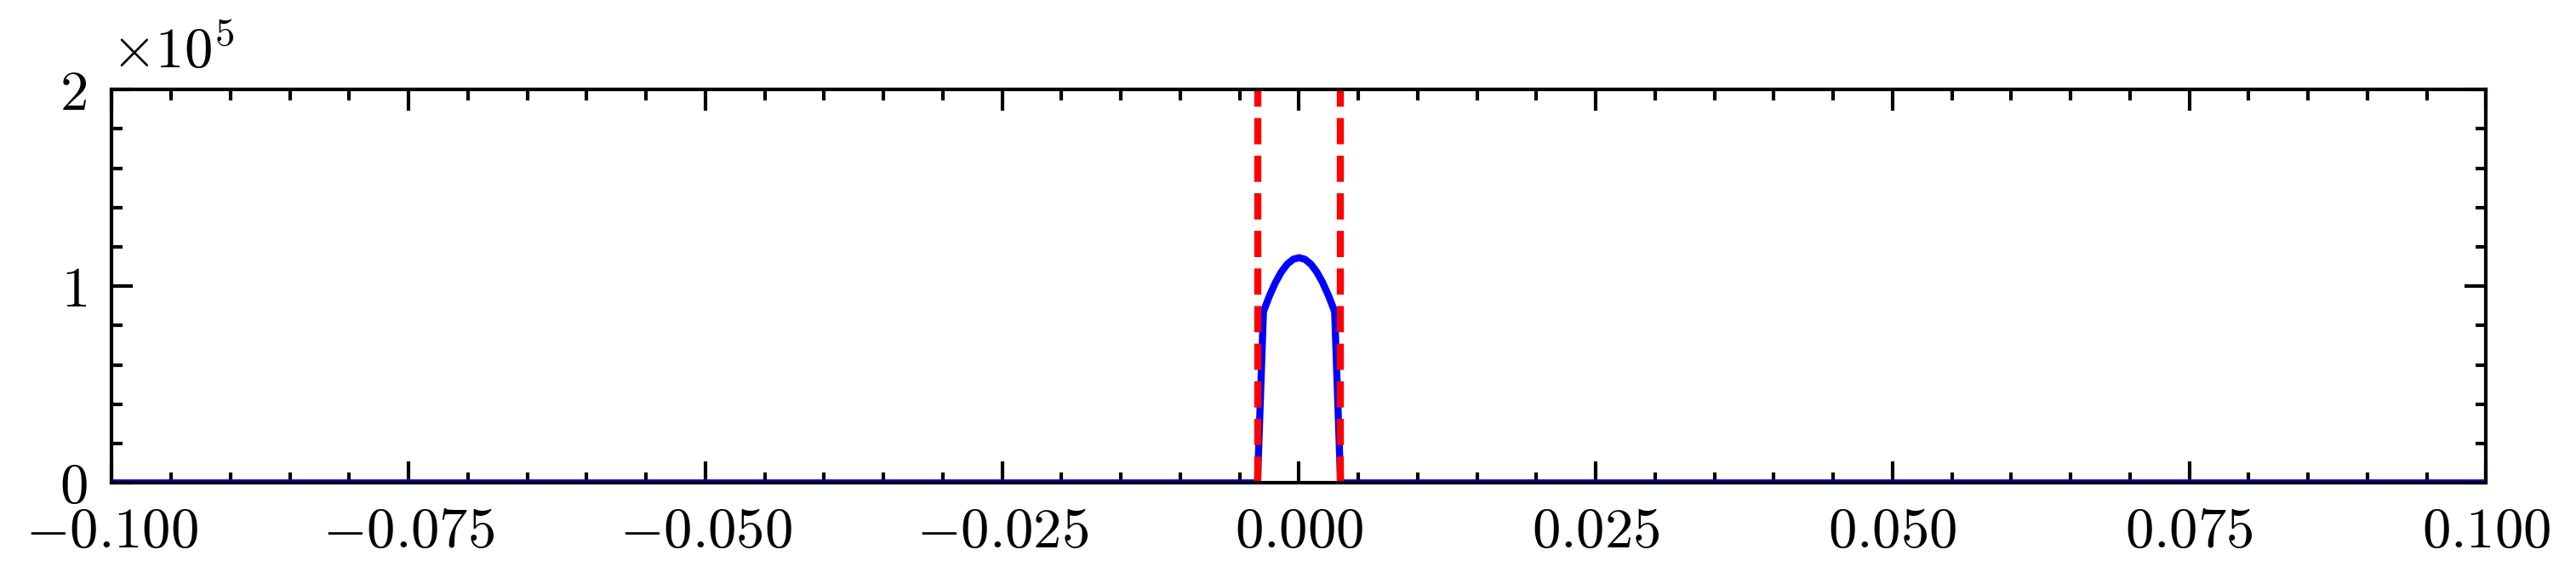

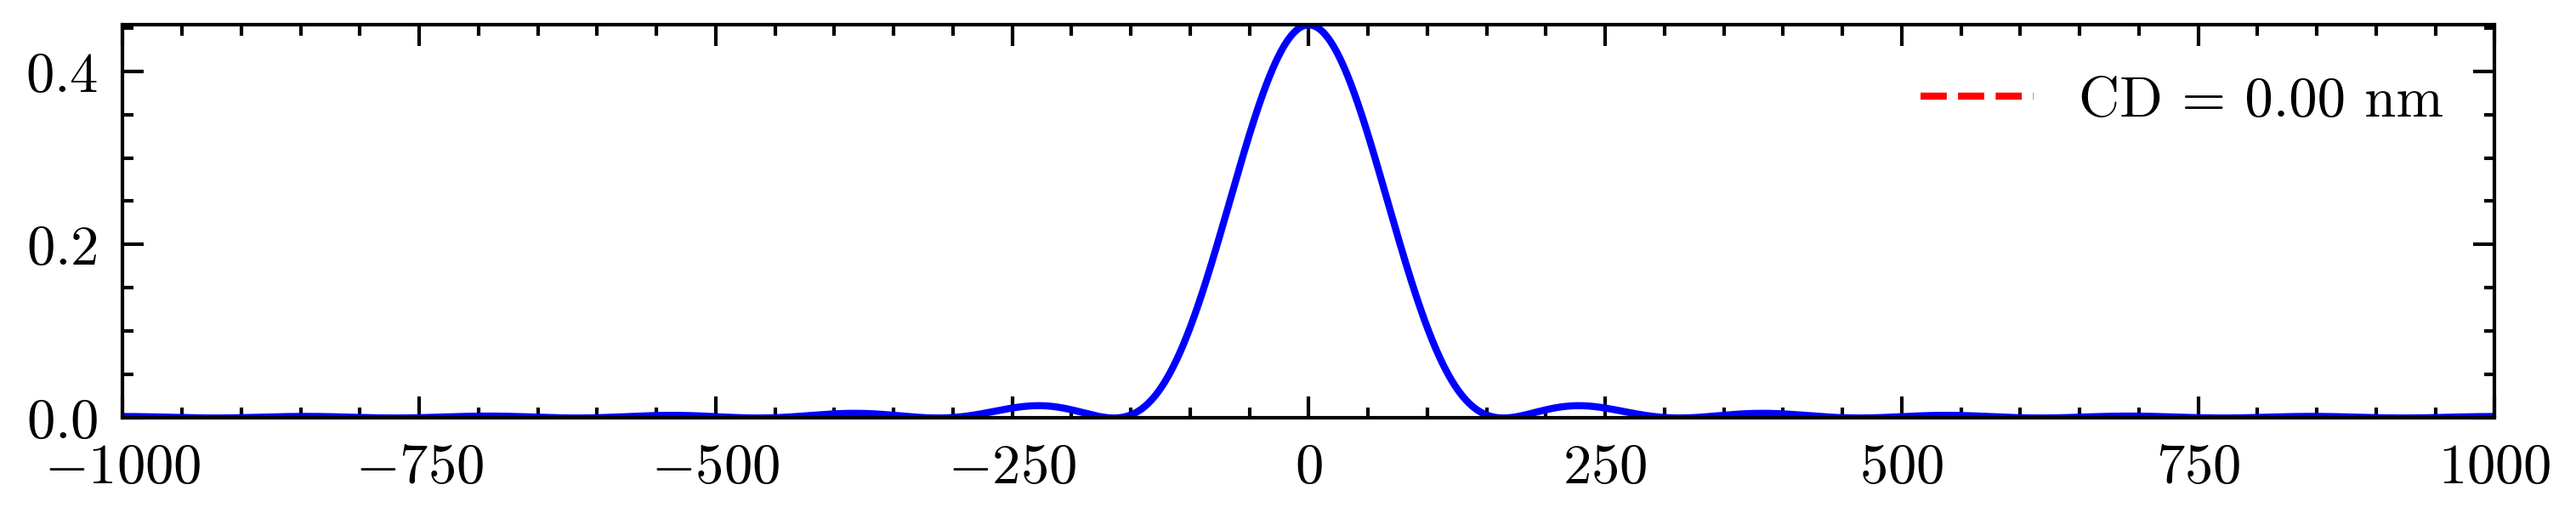

In [14]:
# sim
E_in = np.fft.fft(s_source)
E_in_mask = np.multiply(E_in, s_single_mask)
E_out_unshift = np.fft.fft(E_in_mask)
_, E_out_shift = freq_and_Eoutshift(s_single, E_out_unshift, Fs_single)
# condition specified frequency region
cond = np.abs(freq) <= 0.1
# plot the frequency to E_out_shift
y_max = 2 * s_single_width * Fs_single
plt.figure(figsize=(6, 1))
plt.xlim(-0.1, 0.1)
plt.ylim(0, y_max)
plt.ticklabel_format(
	axis='y', 
	style='sci', 
	scilimits=(5, 5)
)
plt.plot(freq[cond], np.abs(E_out_shift[cond]), 'b-')
plt.savefig(f'./{target_path}/source_FT.png')
plt.figure(figsize=(6, 1))
plt.xlim(-0.1, 0.1)
plt.ylim(0, y_max)
plt.ticklabel_format(
	axis='y', 
	style='sci', 
	scilimits=(5, 5)
)
plt.plot(freq[cond], np.abs(E_out_shift[cond]), 'b-')
plt.axvline(
	x=-W, 
	ymin=0, 
	ymax=y_max, 
	color='r', 
	linestyle='--'
)
plt.axvline(
	x=W, 
	ymin=0, 
	ymax=y_max, 
	color='r', 
	linestyle='--'
)
plt.savefig(f'./{target_path}/source_FT_cutoff.png')
# after exit pupil
E_out_shift_after_exit_pupil = np.where(
	np.abs(freq) <= W, E_out_shift, 0
)
# plot the cut-off region after exit pupil
plt.figure(figsize=(6, 1))
plt.xlim(-0.1, 0.1)
plt.ylim(0, y_max)
plt.ticklabel_format(
	axis='y', 
	style='sci', 
	scilimits=(5, 5)
)
plt.plot(freq[cond], np.abs(E_out_shift_after_exit_pupil[cond]), 'b-')
plt.axvline(
	x=-W, 
	ymin=0, 
	ymax=y_max, 
	color='r', 
	linestyle='--'
)
plt.axvline(
	x=W, 
	ymin=0, 
	ymax=y_max, 
	color='r', 
	linestyle='--'
)
plt.savefig(f'./{target_path}/source_slit_cutoff.png')
# plot the aerial image
E_output = np.fft.ifft(E_out_shift_after_exit_pupil)
I = np.multiply(np.abs(E_output), np.abs(E_output))
try:
	freq_left = np.min(s_single[I >= THRESHOLD])
	freq_right = np.max(s_single[I >= THRESHOLD])
	CD = freq_right - freq_left
except ValueError:
	CD = 0
plt.figure(figsize=(6, 1))
plt.xlim(-s_single_space, s_single_space)
plt.ylim(0, np.max(I))
plt.plot(s_single, I, 'b-')
plt.axhline(THRESHOLD, color='r', linestyle='--', label=f'CD = {CD:.2f} nm')
plt.legend()
plt.savefig(f'./{target_path}/source_slit_aerial.png')